In [1]:
import choclo
import harmonica as hm
import numpy as np
import verde as vd

import magali as mg

<xarray.DataArray 'bz' (y: 501, x: 501)> Size: 2MB
array([[5.4836498 , 5.51402814, 5.54456919, ..., 6.3714142 , 6.33595356,
        6.30067154],
       [5.51492212, 5.54558893, 5.57642103, ..., 6.41163638, 6.37580145,
        6.34014844],
       [5.54637509, 5.57733313, 5.60845909, ..., 6.45212961, 6.41591627,
        6.37988821],
       ...,
       [6.82108403, 6.86494622, 6.90910713, ..., 7.75277765, 7.70352936,
        7.65459715],
       [6.78204673, 6.82548939, 6.86922611, ..., 7.70444146, 7.65570191,
        7.60727305],
       [6.74321465, 6.78624161, 6.82955804, ..., 7.65640305, 7.60816703,
        7.5602364 ]], shape=(501, 501))
Coordinates:
  * x        (x) float64 4kB 0.0 2.0 4.0 6.0 8.0 ... 994.0 996.0 998.0 1e+03
  * y        (y) float64 4kB 0.0 2.0 4.0 6.0 8.0 ... 994.0 996.0 998.0 1e+03
    z        (y, x) float64 2MB 5.0 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0 5.0
Attributes:
    long_name:  vertical magnetic field
    units:      nT
[32.96961852]


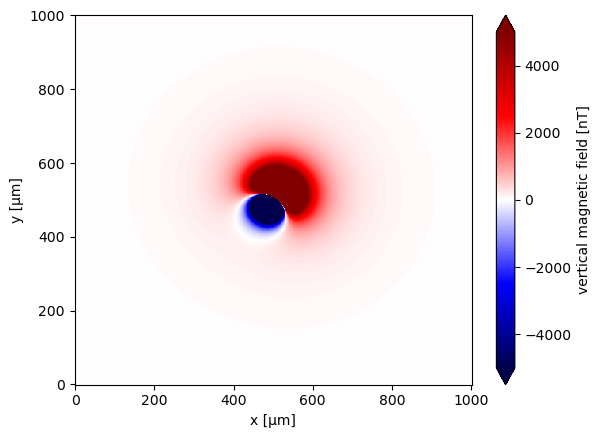

In [2]:
sensor_sample_distance = 5.0  # µm
region = [0, 1000, 0, 1000]  # µm
spacing = 2  # µm

true_inclination = 30
true_declination = 40
true_dispersion_angle = 5

coordinates = vd.grid_coordinates(
    region=region,  # µm
    spacing=spacing,  # µm
    extra_coords=sensor_sample_distance,
)

size = 1

directions_inclination, directions_declination = mg.random_directions(
    true_inclination,
    true_declination,
    true_dispersion_angle,
    size=size,
    random_state=5,
)

dipole_coordinates = (500, 500, -15)

dipole_moments = hm.magnetic_angles_to_vec(
    inclination=directions_inclination,
    declination=directions_declination,
    intensity=5e-11,
)

data = mg.dipole_bz_grid(
    region, spacing, sensor_sample_distance, dipole_coordinates, dipole_moments
)

data.plot.pcolormesh(cmap="seismic", vmin=-5000, vmax=5000)

print(data)

print(directions_declination)

In [3]:
import choclo
import numpy as np
import verde.base as vdb


class MagneticMomentBz:
    r"""
    Estimate magnetic dipole moment vector from Bz measurements.

    Uses the Bz component of the magnetic field to fit a point dipole model,
    returning the dipole moment vector that best fits the data in a
    least-squares sense.

    Parameters
    ----------
    location : tuple of floats
        Coordinates (x, y, z) of the dipole location, in µm.

    Attributes
    ----------
    dipole_moment_ : 1d-array
        Estimated dipole moment vector (mx, my, mz).
    jacobian : 2d-array
        Jacobian matrix evaluated at the data coordinates.

    Methods
    -------
    fit(coordinates, data)
        Fit the dipole model to the Bz component of the magnetic field.

    Notes
    -----
    The input/output magnetic field is assumed to be Bz in nT, and all
    coordinates should be provided in µm. Conversion to SI units is
    handled internally.
    """

    def __init__(self, location):
        self.location = location
        self.dipole_moment_ = None
        self.jacobian = None

    def _calculate_jacobian(self, x, y, z):
        """
        Compute the Jacobian matrix for the point dipole model.

        Parameters
        ----------
        x, y, z : 1d-arrays
            Coordinates of the observations, in micrometers.

        Returns
        -------
        jacobian : 2d-array
            Jacobian matrix (n_observations x 3).
        """
        x_c, y_c, z_c = vdb.n_1d_arrays(self.location, 3)
        factor = choclo.constants.VACUUM_MAGNETIC_PERMEABILITY / (4 * np.pi)
        x = x * mg.MICROMETER_TO_METER
        y = y * mg.MICROMETER_TO_METER
        z = z * mg.MICROMETER_TO_METER
        x_c = x_c * mg.MICROMETER_TO_METER
        y_c = y_c * mg.MICROMETER_TO_METER
        z_c = z_c * mg.MICROMETER_TO_METER
        n_data = x.size
        n_params = 3
        jacobian = [np.zeros(n_data) for _ in range(n_params)]

        for i in range(n_data):
            r = choclo.utils.distance_cartesian(x[i], y[i], z[i], x_c, y_c, z_c)
            kernel_eu = choclo.point.kernel_eu(x[i], y[i], z[i], x_c, y_c, z_c, r)
            kernel_nu = choclo.point.kernel_nu(x[i], y[i], z[i], x_c, y_c, z_c, r)
            kernel_uu = choclo.point.kernel_uu(x[i], y[i], z[i], x_c, y_c, z_c, r)

            jacobian[0][i] = factor * kernel_eu
            jacobian[1][i] = factor * kernel_nu
            jacobian[2][i] = factor * kernel_uu

        return np.stack(jacobian, axis=-1)

    def fit(self, coordinates, data):
        """
        Fit the magnetic dipole model to Bz data.

        Parameters
        ----------
        coordinates : tuple of arrays
            Coordinates (x, y, z) of the observations.
        data : array
            Observed Bz component of the magnetic field (in tesla).

        Returns
        -------
        self
            This estimator instance, updated with the estimated moment vector.
        """
        coordinates, data, _ = vdb.check_fit_input(coordinates, data, weights=None)
        x, y, z = vdb.n_1d_arrays(coordinates, 3)
        data = np.ravel(np.asarray(data))

        jacobian = self._calculate_jacobian(x, y, z)
        self.jacobian = jacobian
        hessian = jacobian.T @ jacobian
        hessian_inv = np.linalg.inv(hessian)
        estimate = hessian_inv @ jacobian.T @ data
        self.dipole_moment_ = estimate * 1e-9
        return self

In [4]:
model = MagneticMomentBz(dipole_coordinates)
model.fit(coordinates, data)

print("True Moment:", dipole_moments)
print("Estimated Moment:", model.dipole_moment_)

/tmp/ipykernel_2683/731277211.py:75: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  jacobian[0][i] = factor * kernel_eu
/tmp/ipykernel_2683/731277211.py:76: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  jacobian[1][i] = factor * kernel_nu
/tmp/ipykernel_2683/731277211.py:77: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  jacobian[2][i] = factor * kernel_uu


True Moment: (array([2.41199063e-11]), array([3.71845505e-11]), array([-2.31417225e-11]))
Estimated Moment: [ 2.41199063e-11  3.71845505e-11 -2.31417225e-11]
